# Spam Ham Email Classification

## Import necessary libraries for this spam ham email cassification natural language processing project.

- 0125118 Lock Jun Lin
- 0125112 Joseph Chang Mun Kit
- 0129219 Victor Chua Min Chun
- 0125942 Kenny Lee Yuan Hong

In [1]:
# utilities
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization library
%matplotlib inline
import seaborn as sns # interactive visualization library built on top on matplotlib
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import collections
from pprint import pprint
from time import time

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn for model training
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import model_selection

# sklearn evaluation metrics
from sklearn.metrics import classification_report,accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# pickle library for exporting model into pkl file
import pickle

# lime explainable AI for explaining result of prediction by machine learning model
import lime
from lime.lime_text import LimeTextExplainer

#warnings
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA)

## This was done to examine and analyze the spam ham dataset to develop a deeper understanding about dataset to better develop the spam ham email classification model.

### Spam Ham dataset downloaded from kaggle.
### Email text that is labelled "ham" represents ham / non-spam email and email text that is labelled "spam" represents spam email.

In [2]:
# Importing the dataset
df = pd.read_csv('spam_ham_dataset.csv')

# Convert the string "label" column to category column
df['label'] = df["label"].astype('category')

# Displaying dataset information and display first 5 row of dataset
print('Size of spam ham training dataset:', df.shape, '\n')
print(df.info())

# Check for Missing Values in dataset If Any
print("\nRows with empty column data in dataset:\n", df.isna().sum())

df.head(5)

Size of spam ham training dataset: (5171, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  5171 non-null   int64   
 1   label       5171 non-null   category
 2   text        5171 non-null   object  
 3   label_num   5171 non-null   int64   
dtypes: category(1), int64(2), object(1)
memory usage: 126.5+ KB
None

Rows with empty column data in dataset:
 Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0

# Distribution of target variable (ham and spam label)

Total number of email labelled as "spam" is 1499.
Total number of email labelled as "ham" is 3672.



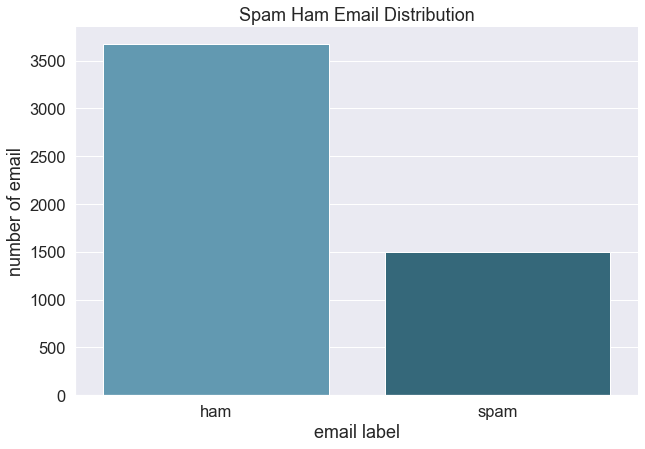

In [3]:
#show total number of email labelled as "spam" and total number of email labeled with "ham"
print("Total number of email labelled as \"spam\" is %d."  %df["text"][df["label"]=="spam"].count())
print("Total number of email labelled as \"ham\" is %d.\n"%df["text"][df["label"]=="ham"].count())

#plot the graph to show how many ham and spam email are there in the spam ham dataset
sns.catplot(x="label", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.xlabel("email label")
plt.ylabel("number of email")
plt.title("Spam Ham Email Distribution")
plt.show()

# Graph of distribution of the number of words in an email text per label class

Word Count
Spam: 234.07738492328218
Ham: 225.21432461873638
Character Count
Spam: 1223.2561707805203
Ham: 977.0081699346405
Unique Word Count
Spam: 122.9346230820547
Ham: 90.37091503267973


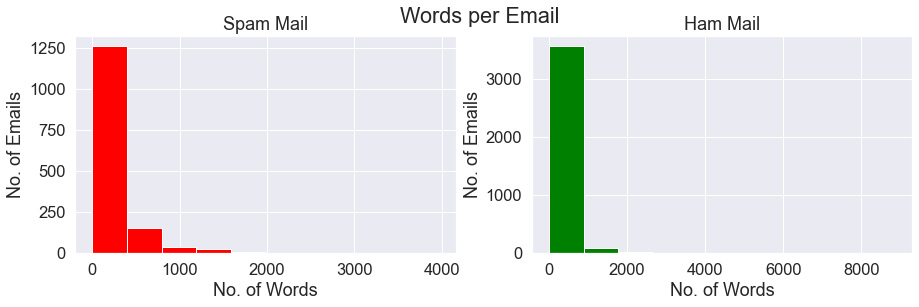

In [4]:
#show word count, character count, and unique word-count of ham and spam email
#1. WORD-COUNT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print("Word Count")
print("Spam:", df[df['label']=="spam"]['word_count'].mean()) #Spam email
print("Ham:", df[df['label']=="ham"]['word_count'].mean()) #Ham email
#Disaster tweets are more wordy than the non-disaster tweets
print("========")

#2. CHARACTER-COUNT
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
print("Character Count")
print("Spam:", df[df['label']=="spam"]['char_count'].mean()) #Spam email
print("Ham:", df[df['label']== "ham"]['char_count'].mean()) #Ham email
#Disaster tweets are longer than the non-disaster tweets
print("========")

#3. UNIQUE WORD-COUNT
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
print("Unique Word Count")
print("Spam:", df[df['label']== "spam"]['unique_word_count'].mean()) #Spam email
print("Ham:", df[df['label']== "ham"]['unique_word_count'].mean()) #Ham email

#Plotting word-count per email according to label of email
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4))
train_words=df[df['label']=="spam"]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Spam Mail')
ax1.set_xlabel('No. of Words')
ax1.set_ylabel('No. of Emails')
train_words=df[df['label']=="ham"]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Ham Mail')
ax2.set_xlabel('No. of Words')
ax2.set_ylabel('No. of Emails')
fig.suptitle('Words per Email')
plt.show()

# Graph of word frequency of email text data

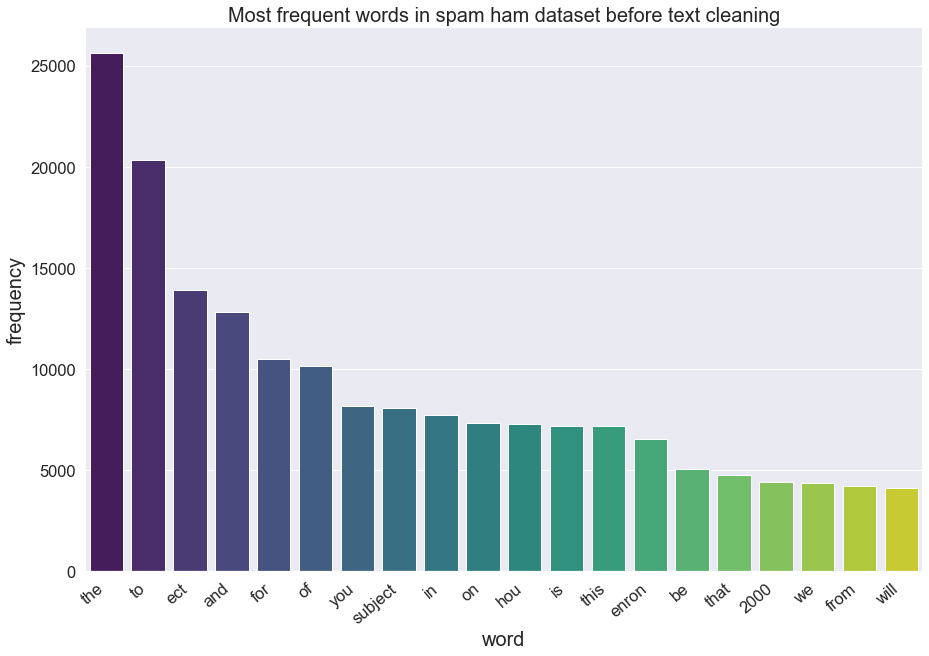

In [5]:
#define function to vectorize text and calculate the most frequent text in email text data
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in email text data before text cleaning
common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#plot graph to show frequency of 20 most frequent words in email text data before text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="text", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in spam ham dataset before text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()

In [6]:
#define a class, TextCounts to analyze the email text attribute
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #count the number of words in each tweet
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        df = pd.DataFrame({'count_words': count_words})
        return df
    
#define object of TestCounts class
tc = TextCounts()
#define new dataframe to store result of analysis of email text
df_eda = tc.fit_transform(df.text)
df_eda['label'] = df.label

# Graph of distribution of number of words in each ham email and spam email

Descriptive stats for count_words
---------------------------------
        count        mean         std  min    25%   50%     75%     max
label                                                                  
ham    3672.0  156.507353  208.532572  2.0  39.75  85.0  198.25  3635.0
spam   1499.0  186.959306  274.092975  1.0  42.00  88.0  193.50  2602.0


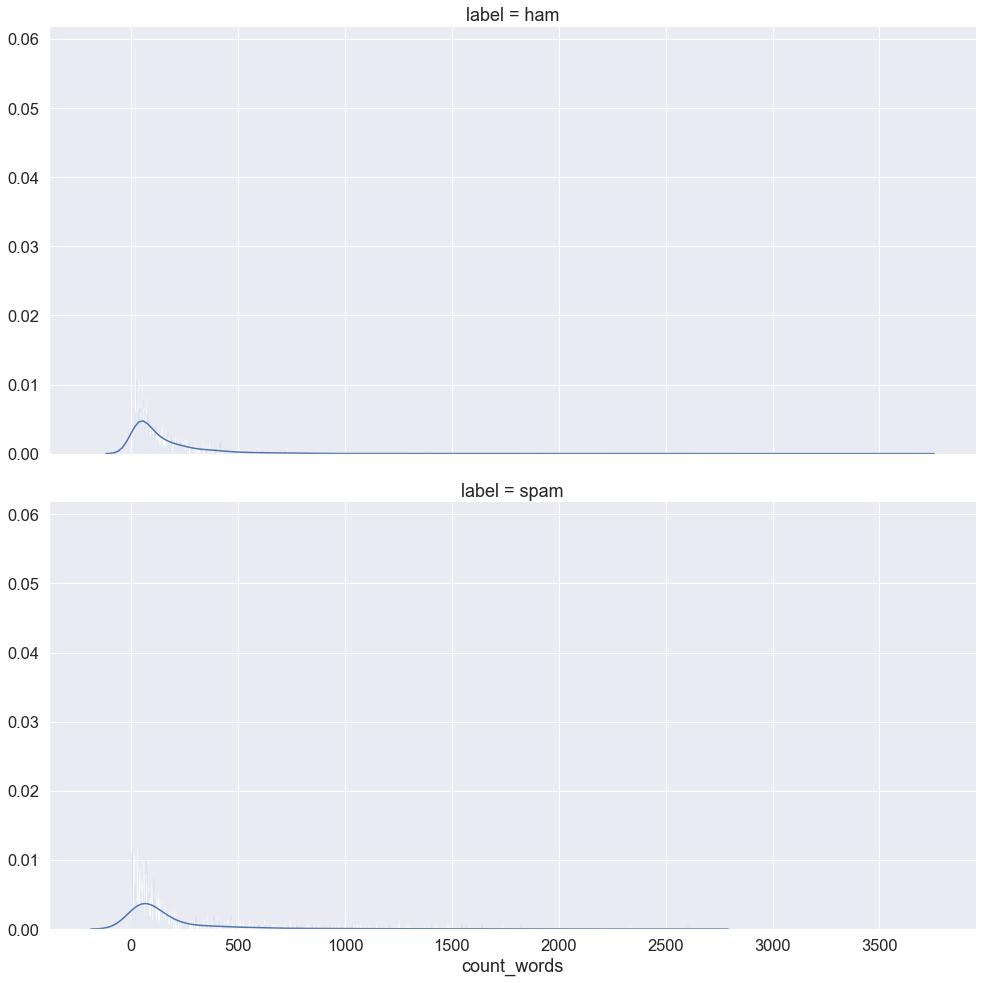

In [7]:
#define function to display graph to visualize word count of spam and ham email
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, row='label', size=7, aspect=2)
    g = g.map(sns.distplot, col, kde=True, norm_hist=True, bins=bins)
    plt.style.use("seaborn-bright")
    plt.show()
    
#plot the graph of word count in each email
show_dist(df_eda, 'count_words')

In [8]:
# retriving text column and label column from dataset as only these 2 column are needed for model training
df2 = df[["text","label"]]
df2.head(5)

text label
0  Subject: enron methanol ; meter # : 988291\r\n...   ham
1  Subject: hpl nom for january 9 , 2001\r\n( see...   ham
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   ham
3  Subject: photoshop , windows , office . cheap ...  spam
4  Subject: re : indian springs\r\nthis deal is t...   ham

# Text Data Preprocessing on Tweet Text Data to Convert Raw Data to Usable Data

1. Remove punctuations mark.
2. Remove all digit or number.
3. Remove stopwords (list of words that do not have any meaning such as a, about, above, etc.).
4. Change multiple spaces into single space.
5. Remove all special characters. (ex: star symbol)
6. Perform lemmatization on the text data to revert the words to its root words.
7. Replacing shorten words such as "re" and "fw" to "reply" and "forward" respective.
8. Remove unwanted words such as "subject" that does not provide any meaning to the text.
9. Lowercase all character in email text data.

- A class is define with all the text processing technique and it is applied to the tweet text data

In [108]:
#define a CleanText class to perform data cleaning on email text data from data set
class CleanText(BaseEstimator, TransformerMixin):
    #replacing the shorten word "re" with "reply"
    def replace_re(self, input_text):
        # counter = 1
        # if counter ==1:
        #     print(counter)
        #     print(re.sub(r'\bre\b', "reply", input_text))
        return re.sub(r'\bre\b', "reply", input_text)
    
    #raplacing the shorten word "fw" with "forward"
    def replace_fw(self, input_text):
        return re.sub(r'\bfw\b', "forward", input_text)
    
    #remove all punctuation from email text data
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    #remove all digit from email text data
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    #change all letter in email text data to lowercase
    def to_lower(self, input_text):
        return input_text.lower()
    
    #remove of leading/trailing whitespace 
    def remove_space(self, input_text):
        return input_text.strip()
    
    #remove extra spaces
    def remove_extra_space(self, input_text):
        return re.sub(r'\s+', ' ', input_text, flags=re.I)
    
    #remove special character
    def remove_special_char(self, input_text):
        return re.sub(r'\W', ' ' , input_text)
    
    #remove all stopwords such as to, i, me, etc. from email text data
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
    
    #remove word "subject" as it appears too often and does not provide any meaning to the text
    def remove_unwanted_words(self, input_text):
        word_remove = ["subject"]
        words = input_text.split()
        word_removed_sent = [word for word in words if (word not in word_remove)]
        return " ".join(word_removed_sent)
    
    #perform lemmatization on each word in email text data to return each word back to its root word without changing the meaning of the word
    def word_lemmatization(self, input_text):
        lemmatizer = WordNetLemmatizer()
        words = input_text.split()
        lemmed_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmed_words)
     
    def fit(self, X, y=None, **fit_params):
        return self
    
    #apply each function in CleanText class to the text dataframe
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(
            self.replace_re).apply(self.replace_fw).apply(self.remove_space).apply(self.remove_extra_space).apply(
            self.remove_special_char).apply(self.remove_stopwords).apply(self.remove_unwanted_words).apply(
            self.word_lemmatization)
        
        #store process output and original text (using first row of email text)
        output = [X[0]]
        #details of output of each step in process of data proprocessing
        output_description = ["\nOrginal Text:-\n", "\nAfter removing all punctuation marks, all digits, and changing all letters to lower case:-\n",
                            "\nAfter replacing short form words ('fw' and 're') to ('forward' and 'reply') respectively:-\n",
                            "\nAfter removing trailing/leading spaces, extra spaces between words and special characters:-\n",
                            "\nAfter removing stopwords and unwanted words (which is the word \"subject\"):-\n", "\nAfter lemmenization of text data:-\n"]
        #change first row of email text to dataframe Series as this class only works on Series object
        X_example = pd.Series(X[45])
        #apply each step of data preprocessing and store into output array for display
        X_example_clean = X_example.apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.replace_re).apply(self.replace_fw)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.remove_space).apply(self.remove_extra_space).apply(self.remove_special_char)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.remove_stopwords).apply(self.remove_unwanted_words)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.word_lemmatization)
        output.append(X_example_clean[0])
        #iterate through each item in both output description and output array and display item accordingly to display output in each data preprocessing step
        print("Text Data Preprocessing Output:-")
        for i in range(len(output)):
            print(output_description[i], output[i], "\n\n==========================================================================================================")

        return clean_X

In [109]:
#define object of CleantText class
ct = CleanText()
#display each output of each step of data preprocessing
sr_clean = ct.fit_transform(df2.text)

Text Data Preprocessing Output:-

Orginal Text:-
 Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes . 


After removing all punctuation marks, all digits, and changing all letters to lower case:-
 subject  re   new production   sitara deals needed
vance  
deals                  and                  have been created and
entered in sitara for hesco  
hillary  
do not confirm  
bob
vance l taylor
           pm
to   robert cotten   hou   ect   ect
cc   lisa hesse   hou   ect   ect   trisha hughes   hou   ect   ect   heidi
withers   hou   ect   ect   hillary mack   corp   enron   enron   susan smith   hou   ect   ect  
donald p reinhardt   hou   ect   ect   melissa graves   hou   ect   ect
subject   new production   sitara 

In [110]:
#display 5 random data of the email text data that has gone through data cleaning
print("Sample of data after data cleaning (5 rows):-\n",sr_clean.sample(5))

#check if there any rows from the dataset has does not have any words left for email text attribute
empty_clean = sr_clean == ''
print('\n{} email have zero words after going though text cleaning.'.format(sr_clean[empty_clean].count()))

#display an example of original text (before cleaning) and cleaned text (after cleaning)
print("\n===========================================================")
print("Original Text (before text cleaning):-\n", df2.text[45])
print("\n===========================================================")
print("Cleaned Text (after text cleaning):-\n", sr_clean[45])

Sample of data after data cleaning (5 rows):-
 4271    alert spam prevention mov sll santa monica blv...
3982    june special summer special valued golfer king...
177     enron hpl acutals october teco tap enron hpl i...
5053    lose pound instantly content type text plain c...
783     double business kerr mcgee gas daily request m...
Name: text, dtype: object

18 email have zero words after going though text cleaning.

Original Text (before text cleaning):-
 Subject: re : new production - sitara deals needed
vance ,
deals # 348725 ( 6 / 10 - 6 / 30 ) and # 348729 ( 7 / 1 - 7 / 31 ) have been created and
entered in sitara for hesco .
hillary ,
do not confirm .
bob
vance l taylor
07 / 28 / 2000 01 : 24 pm
to : robert cotten / hou / ect @ ect
cc : lisa hesse / hou / ect @ ect , trisha hughes / hou / ect @ ect , heidi
withers / hou / ect @ ect , hillary mack / corp / enron @ enron , susan smith / hou / ect @ ect ,
donald p reinhardt / hou / ect @ ect , melissa graves / hou / ect @ ect
sub

# Writing cleaned email text data and the label of the tweet to new csv file

In [11]:
#define a new dataframe to store the cleaned email text data and spam ham label value of email text
df_cleaned = pd.DataFrame({'clean_text': sr_clean, 'label': df2["label"]})
df_cleaned.columns.tolist()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clean_text  5171 non-null   object  
 1   label       5171 non-null   category
dtypes: category(1), object(1)
memory usage: 45.7+ KB


In [12]:
#Drop rows that has email text with no words after text preprocessing
df_cleaned.drop(df_cleaned[df_cleaned.clean_text == ""].index, inplace=True)
df_cleaned.info()

#write cleaned email text data and label of email to new csv file
df_cleaned.to_csv("cleaned_spam_ham_dataset.csv", index=False)
df_cleaned.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5153 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clean_text  5153 non-null   object  
 1   label       5153 non-null   category
dtypes: category(1), object(1)
memory usage: 85.7+ KB


clean_text label
0  enron methanol meter follow note gave monday p...   ham
1  hpl nom january see attached file hplnol xl hp...   ham
2  neon retreat ho ho ho reply around wonderful t...   ham
3  photoshop window office cheap main trending ab...  spam
4  reply indian spring deal book teco pvr revenue...   ham

## Analyze Tweet Text Data after Text Preprocessing was performed on Email Text Data

- Plot word cloud and text frequency graph to analyze cleaned email text data
- Plot word cloud for spam email text data and ham email text data
- Plot text frequency graph of email text data after text data preprocessing

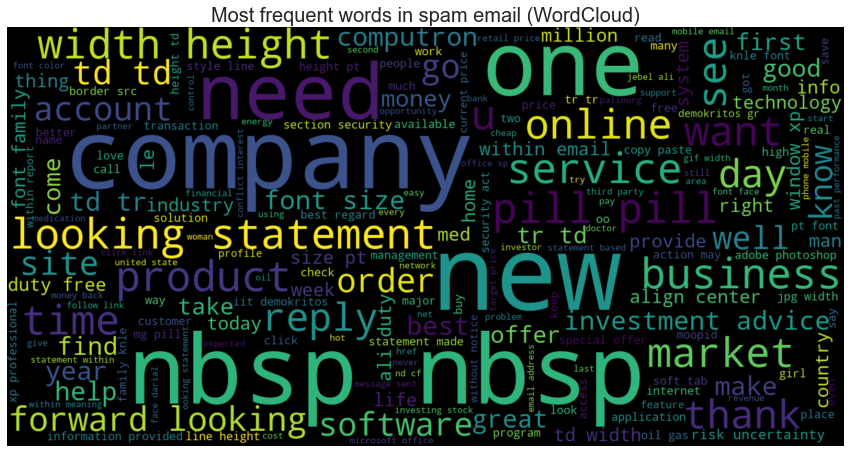

In [13]:
#define a new list variable to store all text data from spam email
spam_tweets = df_cleaned.clean_text[df_cleaned.label == "spam"]
spam_string = []
for t in spam_tweets:
    spam_string.append(t)
#split the text data from string into individual text characters
spam_string = pd.Series(spam_string).str.cat(sep=' ')
#plot a wordcloud to display spam email and the frequency of each text
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(spam_string)
plt.figure(figsize=(15,11))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most frequent words in spam email (WordCloud)", fontsize=20)
plt.axis("off")
plt.show()

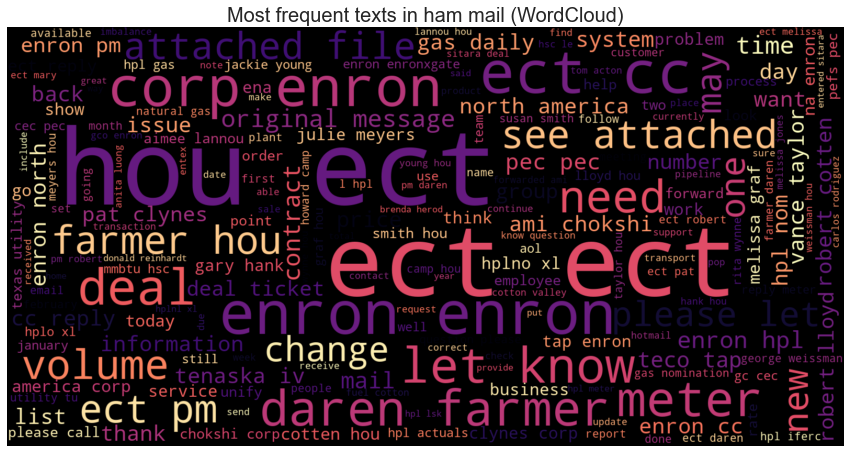

In [14]:
#define a new list variable to store all text data from ham email
ham_tweets = df_cleaned.clean_text[df_cleaned.label == "ham"]
ham_string = []
for t in ham_tweets:
    ham_string.append(t)
#split the text data from string into individual text characters
ham_string = pd.Series(ham_string).str.cat(sep=' ')
#plot a wordcloud to display ham email and the frequency of each text
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(ham_string)
plt.figure(figsize=(15,11))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most frequent texts in ham mail (WordCloud)", fontsize=20)
plt.axis("off")
plt.show()

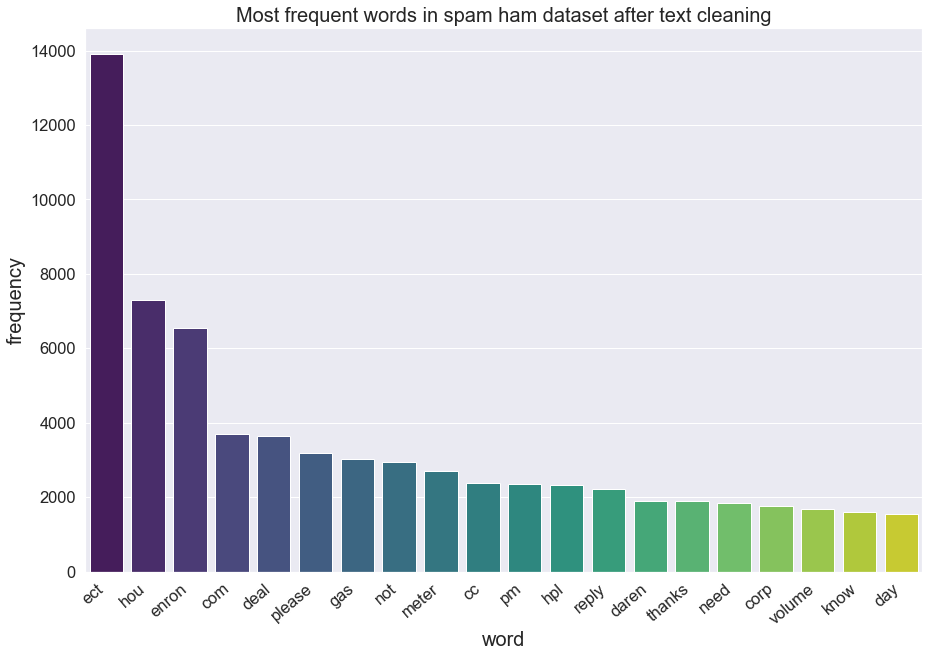

In [15]:
#define function to vectorize text and calculate the most frequent text in email text data (after text preprocessing)
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in email text data after text cleaning
common_words = get_top_n_words(df_cleaned['clean_text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#plot graph to show frequency of 20 most frequent words in email text data after text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="text", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in spam ham dataset after text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()

## Build Model with Logistic Regression Algorithm with TF-IDF Vectorizer

- The machine learning algorithm used is Logistic Regression.
- The confusion matrix constructed from the prediction of logistic regression model.
- The metrics score are printed as well to evaluate the performance of logistic regresison model.
- Hyperparameter tuning and cross validation is performed for training of logistic regression model and tf-idf algorithm feature extraction method to determine the best optimal parameter for the model and tf-idf algorithm.

In [16]:
#define ColumnExtractor class to extract column from dataframe
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
    
#spliting dataset into test data and train data with 20% of data as test data
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop('label', axis=1), 
                                                    df_cleaned.label, test_size=0.2, random_state=37)

In [17]:
#define a grid_vect function to train the model using different parameters and train data to get the logistic regression model with the highest accuracy
#the function will also print out the results of the training and show which parameter produces the best model with the highest accuracy
#Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    pipeline = Pipeline([('features', features), ('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("=================Performing grid search...========================")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    #pprint the parameters that are applied to the machine learning model to determine the best optimal parameters
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    #print time taken to complete Hyperparameter tuning and cross-validation
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

# Parameter grid settings for the TF-IDF vectorizers
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Term Frequency-Inverse Document Frequency (TF-IDF)

In [18]:
#using first 2 rows of email text data in cleaned dataset put into array to show an example
exampleSent = [df_cleaned.clean_text[0], df_cleaned.clean_text[1]]
print("Full Text:-\n", exampleSent)

#defining the object for TF-IDF vectorizer
#using tf-idf (without any parameter as an example) to convert cleaned email text data text into vectors
tfidfvect = TfidfVectorizer()

#showing the workings of tf-idf as an example
#fitting the model and passing our sentences right away:
response= tfidfvect.fit_transform((exampleSent))
print("\nVectors:-\n", response)

#getting feature name of example email text
feature_names = tfidfvect.get_feature_names()
print("\nFeatures:-\n", feature_names)

Full Text:-
 ['enron methanol meter follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose', 'hpl nom january see attached file hplnol xl hplnol xl']

Vectors:-
   (0, 31)	0.17677669529663687
  (0, 8)	0.17677669529663687
  (0, 1)	0.17677669529663687
  (0, 21)	0.17677669529663687
  (0, 3)	0.17677669529663687
  (0, 4)	0.17677669529663687
  (0, 13)	0.17677669529663687
  (0, 24)	0.17677669529663687
  (0, 0)	0.17677669529663687
  (0, 32)	0.17677669529663687
  (0, 36)	0.17677669529663687
  (0, 29)	0.17677669529663687
  (0, 34)	0.17677669529663687
  (0, 5)	0.35355339059327373
  (0, 27)	0.17677669529663687
  (0, 25)	0.17677669529663687
  (0, 26)	0.17677669529663687
  (0, 6)	0.17677669529663687
  (0, 30)	0.17677669529663687
  (0, 7)	0.17677669529663687
  (0, 11)	0.17677669529663687
  (0, 28)	0.17677669529663687
  (0, 20)	0.17677669529663687
  (0, 14)	0.17677669529

In [19]:
#defining the object for logistic regression machin learning model class
logreg = LogisticRegression()

# LogisticRegression
print("TF-IDF Logistic Regression Training...")
optimized_logreg_tfidf = grid_vect(logreg, parameters_logreg, 
                                  X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

TF-IDF Logistic Regression Training...
=================Performing grid search...========================
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
done in 51.083s

Best CV score: 0.983
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.982
Classification Report Test Data
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       748
        spam       0.95      0.99      0.97       283

    accuracy                           0.98      1031
   macro avg       0.97      0.98      0.98      1031
weighted avg       0.98      0.98  

# Confusion Matrix

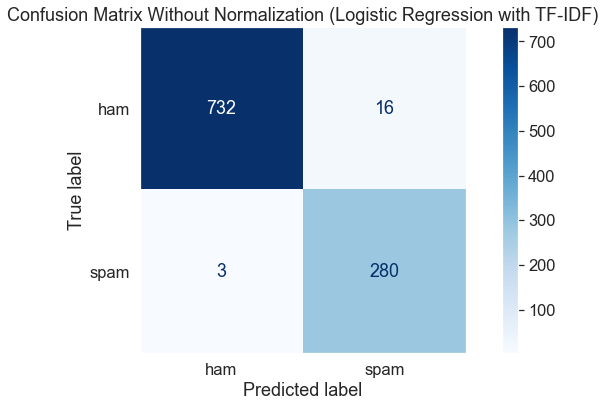

In [20]:
#Plotting a confusion matrix graph to to evaluate the logistic regression model with TF-IDF vectorizer
fig, ax = plt.subplots(figsize=(13, 6))
disp = plot_confusion_matrix(optimized_logreg_tfidf, X_test, y_test, cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title("Confusion Matrix Without Normalization (Logistic Regression with TF-IDF)")
#remove white grid lines from the graph
plt.grid(False)
plt.show()

# Evaluation Metrics of Both TF-IDF Logistic Regression Model with Precision-Curve Curve graph

In [21]:
#Evaluating logistic regression model that are trained with text data that are vectorized using tfidf method using test dataset
lr_tfidf_predict = optimized_logreg_tfidf.predict(X_test)

#calculate the evaluation metrics of the TF-IDF logistic regression model
lr_tfidf_accuracy = accuracy_score(y_test, lr_tfidf_predict)
lr_tfidf_precision = precision_score(y_test, lr_tfidf_predict, average='weighted')
lr_tfidf_recall = recall_score(y_test, lr_tfidf_predict, average='weighted')
lr_tfidf_f1 = f1_score(y_test, lr_tfidf_predict, average='weighted')
print("TFIDF LOGISTIC REGRESSION MODEL\nAccuracy score: %.3f%%\nPrecision score: %.3f%%\nRecall score: %.3f%%\nF1 score: %.3f%%\n" %(lr_tfidf_accuracy*100, lr_tfidf_precision*100,lr_tfidf_recall*100, lr_tfidf_f1*100))

TFIDF LOGISTIC REGRESSION MODEL
Accuracy score: 98.157%
Precision score: 98.220%
Recall score: 98.157%
F1 score: 98.170%



Logistic Regression Model with TF-IDF: f1=0.967 auc=0.994


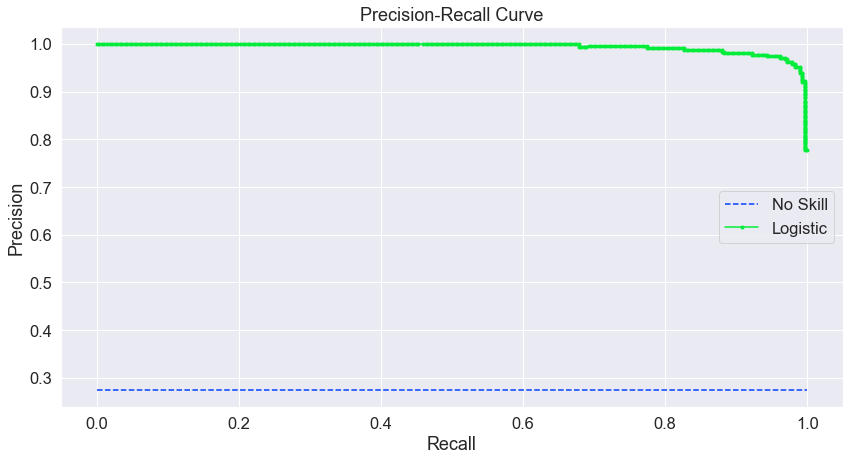

In [22]:
#Creating logistic regression model with the best parameters given by grid search (hyperparameter tuning)
best_tfidf_vc = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1, 1))
best_logreg = LogisticRegression(penalty='l2', C=1.0)
X_train_tfidf = best_tfidf_vc.fit_transform(X_train["clean_text"])
X_test_tfidf = best_tfidf_vc.transform(X_test["clean_text"])
best_logreg.fit(X_train_tfidf, y_train)

# predict probabilities
lr_probs = best_logreg.predict_proba(X_test_tfidf)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = best_logreg.predict(X_test_tfidf)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs, pos_label='spam')
lr_f1= f1_score(y_test, yhat, pos_label='spam')
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('Logistic Regression Model with TF-IDF: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test=="spam"]) / len(y_test)
plt.figure(figsize=(14, 7))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.title("Precision-Recall Curve")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Lime Explainable AI (to explain how the model works and classifies the email)

Row chosen from dataset: 123
Probability(spam) = 0.0642655589454861
Probability(ham) = 0.9357344410545139
True class: ham


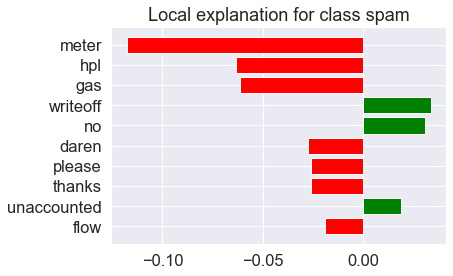

In [23]:
#define class name to classify text data from selected row
class_names = ['ham', 'spam']
logreg_tfidf_pipe = make_pipeline(best_tfidf_vc, best_logreg)
explainer = LimeTextExplainer(class_names = class_names)

#selected row from original dataset to explain machine model (change the value of the variable to choose row)
idx = 123

#use lime to explain the prediction made by the logistic model and display the results
exp = explainer.explain_instance(df.text[idx], logreg_tfidf_pipe.predict_proba, num_features = 10)
print("Row chosen from dataset: %s" % idx)
print(f"Probability(spam) = {logreg_tfidf_pipe.predict_proba([df.text[idx]])[0,1]}")
print(f"Probability(ham) = {logreg_tfidf_pipe.predict_proba([df.text[idx]])[0,0]}")
print('True class: %s' % df.label[idx])
exp.show_in_notebook(text=True)
fig = exp.as_pyplot_figure()

## Input Email to classify if email is spam or ham
- Lime Explainable AI is also used to explain the result of the classification

Enter your mail here:  Congratulations🎈- atos104 🎁  There is one just one thing that makes your dream become impossible and that is the fear of failure   You have been selected to get an exclusive reward! To qualify for this special offer, simply complete our 30-second marketing survey about your experiences with Home Depot.  Start Now  For More Information Click here


c

Entered Email Text (before cleaning): Congratulations🎈- atos104 🎁  There is one just one thing that makes your dream become impossible and that is the fear of failure   You have been selected to get an exclusive reward! To qualify for this special offer, simply complete our 30-second marketing survey about your experiences with Home Depot.  Start Now  For More Information Click here 

Entered Email Text (after cleaning): congratulation atos one one thing make dream become impossible fear failure selected get exclusive reward qualify special offer simply complete second marketing survey experience home depot start information click 

Classification Result: spam
Probability(spam) = 0.7707556215882762
Probability(ham) = 0.22924437841172385


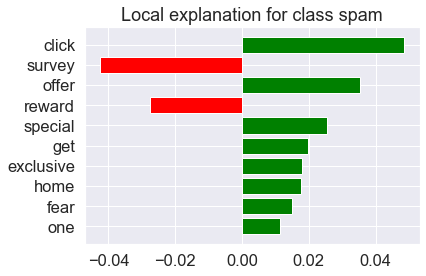

In [24]:
#request for user input of email and classify entered email
text_input = input("Enter your mail here: ")
#convert user input into Series for text cleaning
ex_text =  pd.Series([text_input])
#text cleaning of entered email by user and display result
ex_text_clean = ct.transform(ex_text)
print("\nEntered Email Text (before cleaning):", ex_text[0], "\n\nEntered Email Text (after cleaning):", ex_text_clean[0],
      "\n\nClassification Result:", logreg_tfidf_pipe.predict(ex_text_clean)[0])

#use lime to explain the prediction made by the logistic model and display the results
exp = explainer.explain_instance(ex_text_clean[0], logreg_tfidf_pipe.predict_proba, num_features = 10)
print(f"Probability(spam) = {logreg_tfidf_pipe.predict_proba(ex_text_clean)[0,1]}")
print(f"Probability(ham) = {logreg_tfidf_pipe.predict_proba(ex_text_clean)[0,0]}")
exp.show_in_notebook(text=True)
fig = exp.as_pyplot_figure()

# Export (save) logistic regression model and feature extraction TF-IDF algorithm into pickle file
### This is done so in order for the model to be used for the application without the need to train the model all over again as the trained model is loaded from the pickle file.

In [25]:
#declare file name for trained logistic regression model and tf-idf vectorizer
model_filename = 'lr_model.pkl'
vector_filename = 'tfidf_vectorizer.pkl'
#export and save both model and vectorizer into respective pkl file
pickle.dump(best_logreg, open(model_filename, 'wb'))
pickle.dump(best_tfidf_vc, open(vector_filename, 'wb'))

# This section is to demonstrate how to load the model and apply the model
# # load the model and vectorizer from respective file in given filename/directory
# loaded_model = pickle.load(open('lr_model.pkl', 'rb'))
# loaded_vector = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
# X_train_tfidf2 = loaded_vector.fit_transform(X_train["clean_text"])
# X_test_tfidf2 = loaded_vector.transform(X_test["clean_text"])
# result = loaded_model.score(X_test_tfidf2, y_test)
# print("Logistic Regression with TFIDF (accuracy score): %.2f%%" %(result * 100))